In [1]:
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp
import pylab as plt
from sklearn.model_selection import train_test_split

###Data preparation

In [2]:
df = pd.read_csv("songsDataset.csv", header=0, names=['userID','songID','rating'])

In [3]:
# Calculate the size of each partition
total_size = len(df)
train_size = total_size * 8 // 10  # 80% for training
test_size = total_size - train_size  # Remaining 20% for testing
partition_sizes = [train_size // 8] * 8 + [test_size // 2] * 2

# Shuffle the DataFrame rows
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled DataFrame into partitions
partitions = [df_shuffled.iloc[i:i+size] for i, size in enumerate(partition_sizes)]

# Assign partitions to train and test datasets
train_datasets = partitions[:8]
test_datasets = partitions[8:]

train_datasets[0]

,userID,songID,rating
0,182840,68252,5
1,120007,52200,4
2,19484,135894,5
3,162905,81768,3
4,19114,68130,3
...,...,...,...
199995,86344,39250,5
199996,145630,114471,5
199997,106873,83382,4
199998,48420,18603,5


In [4]:
N_songs = df['songID'].nunique()
N_users = df['userID'].nunique()
N_ratings = df.shape[0]
print(N_songs)
print(N_users)

127771
200000


In [7]:
song_ids = list(df['songID'].unique())

### 500 iterations, learning rate 0.01

In [5]:
d_factors = 10
U_init = np.random.normal(3,1,size=(N_users,d_factors))/np.sqrt(d_factors) # midpoint of the rating scale
S_init = np.random.normal(3,1,size=(N_songs,d_factors))/np.sqrt(d_factors)

In [6]:
@jax.jit
def loss(U_single,S_single,rating_single):
    pred = jnp.dot(U_single,S_single)
    error = (rating_single-pred)**2
    return error
loss_grad = jax.jit(jax.grad(loss,argnums=(0,1)))

def mse(U_batch,S_batch,ratings_batch):
    predictions = np.sum(U_batch*S_batch,axis=1)
    errors = (ratings_batch-predictions)**2
    return np.mean(errors)

In [12]:
niter = 500
learning_rate = 0.01
MSE_nmf = []


# Concatenate all 8 training datasets into a single dataset
combined_train_df = pd.concat(train_datasets, ignore_index=True)
combined_test_df = pd.concat(test_datasets, ignore_index=True)

# Initialize U and S matrices
U = U_init.copy()
S = S_init.copy()

for it in range(niter):
    for index in range(20000):
        # Randomly sample from the combined training dataset
        index = np.random.randint(len(combined_train_df))
        user_id = combined_train_df.iloc[index]['userID']
        song_id = combined_train_df.iloc[index]['songID']
        song_index = song_ids.index(song_id)
        rating = combined_train_df.iloc[index]['rating']

        # Compute gradients and update U and S
        U_grad, S_grad = loss_grad(U[user_id], S[song_index], rating)
        U[user_id] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    # Clip U and S to ensure non-negativity
    U = np.maximum(U, 0)
    S = np.maximum(S, 0)

    if ((it+1) % 10 == 0) or (it == 0):
        train_user_ids = combined_train_df['userID'][:10000].values
        train_song_ids = combined_train_df['songID'][:10000].values
        train_song_indices = [song_ids.index(song_id) for song_id in train_song_ids]
        # Compute MSE for the combined training dataset
        U_batch = U[train_user_ids]
        S_batch = S[train_song_indices]
        ratings_batch = combined_train_df['rating'][:10000]
        mse_train = mse(U_batch, S_batch, ratings_batch)
        # Compute MSE for the combined test dataset
        test_user_ids = combined_test_df['userID'][:10000].values
        test_song_ids = combined_test_df['songID'][:10000].values
        test_song_indices = [song_ids.index(song_id) for song_id in test_song_ids]
        # Compute MSE for the combined training dataset
        U_batch_test = U[test_user_ids]
        S_batch_test = S[test_song_indices]
        ratings_batch_test = combined_test_df['rating'][:10000]
        mse_test = mse(U_batch_test, S_batch_test, ratings_batch_test)
        MSE_nmf.append((mse_train, mse_test))
        print(f"Iteration {it+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 22.85499, Test MSE: 22.86051
Iteration 10, Train MSE: 7.38847, Test MSE: 7.39494
Iteration 20, Train MSE: 3.93258, Test MSE: 3.93764
Iteration 30, Train MSE: 2.56239, Test MSE: 2.56306
Iteration 40, Train MSE: 1.88214, Test MSE: 1.88329
Iteration 50, Train MSE: 1.47076, Test MSE: 1.47145
Iteration 60, Train MSE: 1.19740, Test MSE: 1.19814
Iteration 70, Train MSE: 0.99476, Test MSE: 0.99534
Iteration 80, Train MSE: 0.85062, Test MSE: 0.85104
Iteration 90, Train MSE: 0.72784, Test MSE: 0.72822
Iteration 100, Train MSE: 0.62752, Test MSE: 0.62806
Iteration 110, Train MSE: 0.55625, Test MSE: 0.55681
Iteration 120, Train MSE: 0.47911, Test MSE: 0.47949
Iteration 130, Train MSE: 0.41772, Test MSE: 0.41796
Iteration 140, Train MSE: 0.36097, Test MSE: 0.36093
Iteration 150, Train MSE: 0.31842, Test MSE: 0.31835
Iteration 160, Train MSE: 0.27886, Test MSE: 0.27889
Iteration 170, Train MSE: 0.24679, Test MSE: 0.24675
Iteration 180, Train MSE: 0.21658, Test MSE: 0.21651
It

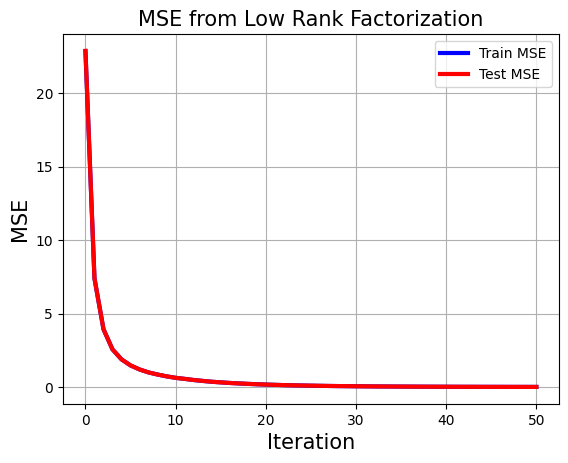

In [13]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=3, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=3, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

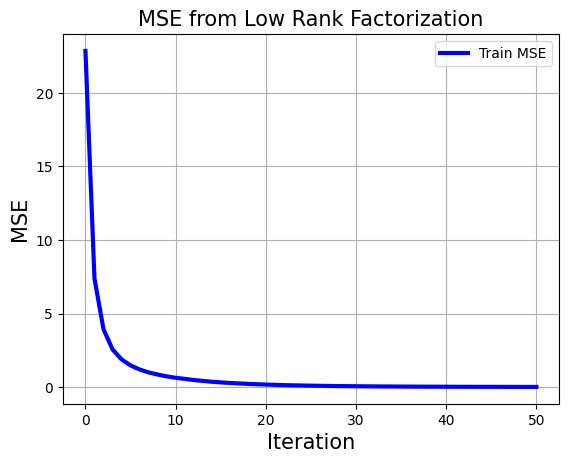

In [14]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=3, color='blue', label='Train MSE')

plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

In [23]:
test_user = combined_test_df['userID'].values
test_song = combined_test_df['songID'].values
test_song_index = [song_ids.index(song_id) for song_id in test_song]
print(test_user)
print(test_user.shape)
print(len(test_song_index))
# Compute MSE for the combined training dataset
U_batch_test = U[test_user]
S_batch_test = S[test_song_index]
print(U_batch_test.shape)
print(S_batch_test.shape)
ratings_batch_test = combined_test_df['rating']
print(ratings_batch_test)
print(ratings_batch_test.shape)

[148447 171584  85657 ...  94458  49466 182772]
(400000,)
400000
(400000, 10)
(400000, 10)
0         1
1         3
2         5
3         1
4         4
         ..
399995    3
399996    5
399997    5
399998    5
399999    4
Name: rating, Length: 400000, dtype: int64
(400000,)


In [21]:
MSE_test = mse(U_batch_test, S_batch_test, ratings_batch_test)

In [22]:
MSE_test

0.009280945128165656

### 200 iterations, learning rate 0.03

In [8]:
niter = 200
learning_rate = 0.03
MSE_nmf = []


# Concatenate all 8 training datasets into a single dataset
combined_train_df = pd.concat(train_datasets, ignore_index=True)
combined_test_df = pd.concat(test_datasets, ignore_index=True)

# Initialize U and S matrices
U = U_init.copy()
S = S_init.copy()

for it in range(niter):
    for index in range(20000):
        # Randomly sample from the combined training dataset
        index = np.random.randint(len(combined_train_df))
        user_id = combined_train_df.iloc[index]['userID']
        song_id = combined_train_df.iloc[index]['songID']
        song_index = song_ids.index(song_id)
        rating = combined_train_df.iloc[index]['rating']

        # Compute gradients and update U and S
        U_grad, S_grad = loss_grad(U[user_id], S[song_index], rating)
        U[user_id] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    # Clip U and S to ensure non-negativity
    U = np.maximum(U, 0)
    S = np.maximum(S, 0)

    if ((it+1) % 10 == 0) or (it == 0):
        train_user_ids = combined_train_df['userID'][:10000].values
        train_song_ids = combined_train_df['songID'][:10000].values
        train_song_indices = [song_ids.index(song_id) for song_id in train_song_ids]
        # Compute MSE for the combined training dataset
        U_batch = U[train_user_ids]
        S_batch = S[train_song_indices]
        ratings_batch = combined_train_df['rating'][:10000]
        mse_train = mse(U_batch, S_batch, ratings_batch)
        # Compute MSE for the combined test dataset
        test_user_ids = combined_test_df['userID'][:10000].values
        test_song_ids = combined_test_df['songID'][:10000].values
        test_song_indices = [song_ids.index(song_id) for song_id in test_song_ids]
        # Compute MSE for the combined training dataset
        U_batch_test = U[test_user_ids]
        S_batch_test = S[test_song_indices]
        ratings_batch_test = combined_test_df['rating'][:10000]
        mse_test = mse(U_batch_test, S_batch_test, ratings_batch_test)
        MSE_nmf.append((mse_train, mse_test))
        print(f"Iteration {it+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 18.03851, Test MSE: 18.02823
Iteration 10, Train MSE: 4.40861, Test MSE: 4.42027
Iteration 20, Train MSE: 2.03264, Test MSE: 2.03221
Iteration 30, Train MSE: 1.27951, Test MSE: 1.28006
Iteration 40, Train MSE: 0.79635, Test MSE: 0.79628
Iteration 50, Train MSE: 0.51930, Test MSE: 0.51931
Iteration 60, Train MSE: 0.36749, Test MSE: 0.36682
Iteration 70, Train MSE: 0.25742, Test MSE: 0.25658
Iteration 80, Train MSE: 0.18247, Test MSE: 0.18201
Iteration 90, Train MSE: 0.13719, Test MSE: 0.13667
Iteration 100, Train MSE: 0.09912, Test MSE: 0.09820
Iteration 110, Train MSE: 0.07519, Test MSE: 0.07424
Iteration 120, Train MSE: 0.05588, Test MSE: 0.05581
Iteration 130, Train MSE: 0.04240, Test MSE: 0.04198
Iteration 140, Train MSE: 0.03346, Test MSE: 0.03313
Iteration 150, Train MSE: 0.02551, Test MSE: 0.02549
Iteration 160, Train MSE: 0.01992, Test MSE: 0.01963
Iteration 170, Train MSE: 0.01586, Test MSE: 0.01571
Iteration 180, Train MSE: 0.01302, Test MSE: 0.01291
It

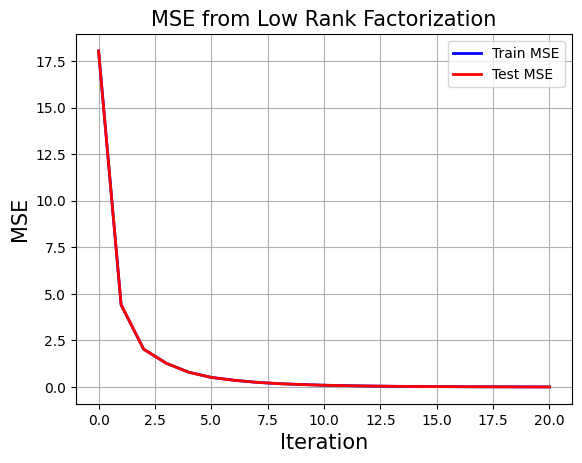

In [9]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=2, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

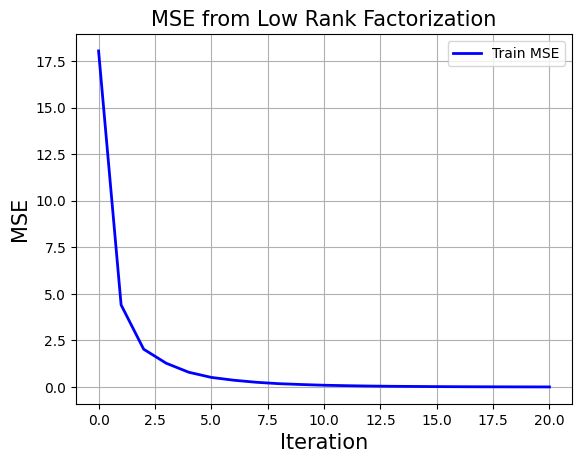

In [10]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')

plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

In [11]:
test_user = combined_test_df['userID'].values
test_song = combined_test_df['songID'].values
test_song_index = [song_ids.index(song_id) for song_id in test_song]
# Compute MSE for the combined training dataset
U_batch_test = U[test_user]
S_batch_test = S[test_song_index]
ratings_batch_test = combined_test_df['rating']
MSE_test = mse(U_batch_test, S_batch_test, ratings_batch_test)
MSE_test

0.008332045051748277

### 200 iterations, learning rate 0.05

In [12]:
niter = 200
learning_rate = 0.05
MSE_nmf = []


# Concatenate all 8 training datasets into a single dataset
combined_train_df = pd.concat(train_datasets, ignore_index=True)
combined_test_df = pd.concat(test_datasets, ignore_index=True)

# Initialize U and S matrices
U = U_init.copy()
S = S_init.copy()

for it in range(niter):
    for index in range(20000):
        # Randomly sample from the combined training dataset
        index = np.random.randint(len(combined_train_df))
        user_id = combined_train_df.iloc[index]['userID']
        song_id = combined_train_df.iloc[index]['songID']
        song_index = song_ids.index(song_id)
        rating = combined_train_df.iloc[index]['rating']

        # Compute gradients and update U and S
        U_grad, S_grad = loss_grad(U[user_id], S[song_index], rating)
        U[user_id] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    # Clip U and S to ensure non-negativity
    U = np.maximum(U, 0)
    S = np.maximum(S, 0)

    if ((it+1) % 10 == 0) or (it == 0):
        train_user_ids = combined_train_df['userID'][:10000].values
        train_song_ids = combined_train_df['songID'][:10000].values
        train_song_indices = [song_ids.index(song_id) for song_id in train_song_ids]
        # Compute MSE for the combined training dataset
        U_batch = U[train_user_ids]
        S_batch = S[train_song_indices]
        ratings_batch = combined_train_df['rating'][:10000]
        mse_train = mse(U_batch, S_batch, ratings_batch)
        # Compute MSE for the combined test dataset
        test_user_ids = combined_test_df['userID'][:10000].values
        test_song_ids = combined_test_df['songID'][:10000].values
        test_song_indices = [song_ids.index(song_id) for song_id in test_song_ids]
        # Compute MSE for the combined training dataset
        U_batch_test = U[test_user_ids]
        S_batch_test = S[test_song_indices]
        ratings_batch_test = combined_test_df['rating'][:10000]
        mse_test = mse(U_batch_test, S_batch_test, ratings_batch_test)
        MSE_nmf.append((mse_train, mse_test))
        print(f"Iteration {it+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 17.97973, Test MSE: 17.98026
Iteration 10, Train MSE: 4.99396, Test MSE: 4.98999
Iteration 20, Train MSE: 2.43088, Test MSE: 2.43257
Iteration 30, Train MSE: 1.33981, Test MSE: 1.33977
Iteration 40, Train MSE: 0.72815, Test MSE: 0.72837
Iteration 50, Train MSE: 0.45225, Test MSE: 0.45195
Iteration 60, Train MSE: 0.29448, Test MSE: 0.29441
Iteration 70, Train MSE: 0.18443, Test MSE: 0.18446
Iteration 80, Train MSE: 0.11998, Test MSE: 0.11993
Iteration 90, Train MSE: 0.07833, Test MSE: 0.07835
Iteration 100, Train MSE: 0.05343, Test MSE: 0.05341
Iteration 110, Train MSE: 0.03746, Test MSE: 0.03737
Iteration 120, Train MSE: 0.02738, Test MSE: 0.02736
Iteration 130, Train MSE: 0.01972, Test MSE: 0.01971
Iteration 140, Train MSE: 0.01397, Test MSE: 0.01396
Iteration 150, Train MSE: 0.01036, Test MSE: 0.01035
Iteration 160, Train MSE: 0.00810, Test MSE: 0.00809
Iteration 170, Train MSE: 0.00591, Test MSE: 0.00590
Iteration 180, Train MSE: 0.00463, Test MSE: 0.00462
It

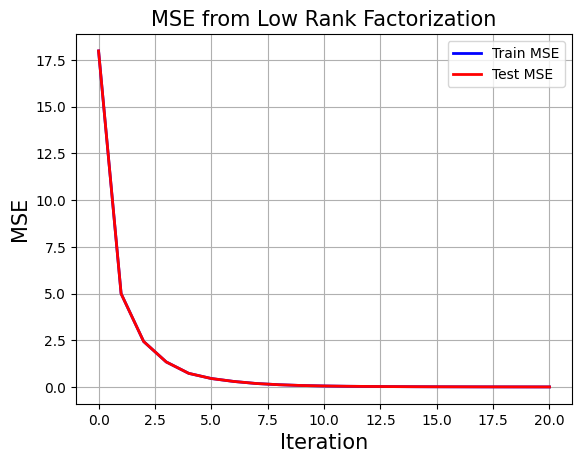

In [13]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=2, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

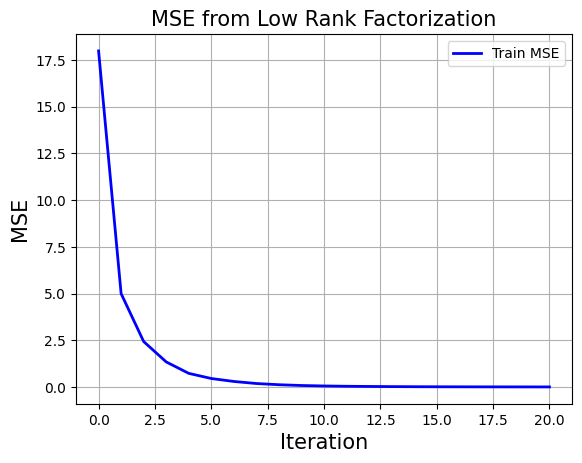

In [14]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')

plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

In [15]:
test_user = combined_test_df['userID'].values
test_song = combined_test_df['songID'].values
test_song_index = [song_ids.index(song_id) for song_id in test_song]
# Compute MSE for the combined training dataset
U_batch_test = U[test_user]
S_batch_test = S[test_song_index]
ratings_batch_test = combined_test_df['rating']
MSE_test = mse(U_batch_test, S_batch_test, ratings_batch_test)
MSE_test

0.0025143757415566183

### 200 iterations, learning rate 0.05, initialization (0,1)

In [16]:
d_factors = 10
U_init = np.random.normal(0,1,size=(N_users,d_factors))/np.sqrt(d_factors) # midpoint of the rating scale
S_init = np.random.normal(0,1,size=(N_songs,d_factors))/np.sqrt(d_factors)

In [17]:
niter = 200
learning_rate = 0.05
MSE_nmf = []


# Concatenate all 8 training datasets into a single dataset
combined_train_df = pd.concat(train_datasets, ignore_index=True)
combined_test_df = pd.concat(test_datasets, ignore_index=True)

# Initialize U and S matrices
U = U_init.copy()
S = S_init.copy()

for it in range(niter):
    for index in range(20000):
        # Randomly sample from the combined training dataset
        index = np.random.randint(len(combined_train_df))
        user_id = combined_train_df.iloc[index]['userID']
        song_id = combined_train_df.iloc[index]['songID']
        song_index = song_ids.index(song_id)
        rating = combined_train_df.iloc[index]['rating']

        # Compute gradients and update U and S
        U_grad, S_grad = loss_grad(U[user_id], S[song_index], rating)
        U[user_id] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    # Clip U and S to ensure non-negativity
    U = np.maximum(U, 0)
    S = np.maximum(S, 0)

    if ((it+1) % 10 == 0) or (it == 0):
        train_user_ids = combined_train_df['userID'][:10000].values
        train_song_ids = combined_train_df['songID'][:10000].values
        train_song_indices = [song_ids.index(song_id) for song_id in train_song_ids]
        # Compute MSE for the combined training dataset
        U_batch = U[train_user_ids]
        S_batch = S[train_song_indices]
        ratings_batch = combined_train_df['rating'][:10000]
        mse_train = mse(U_batch, S_batch, ratings_batch)
        # Compute MSE for the combined test dataset
        test_user_ids = combined_test_df['userID'][:10000].values
        test_song_ids = combined_test_df['songID'][:10000].values
        test_song_indices = [song_ids.index(song_id) for song_id in test_song_ids]
        # Compute MSE for the combined training dataset
        U_batch_test = U[test_user_ids]
        S_batch_test = S[test_song_indices]
        ratings_batch_test = combined_test_df['rating'][:10000]
        mse_test = mse(U_batch_test, S_batch_test, ratings_batch_test)
        MSE_nmf.append((mse_train, mse_test))
        print(f"Iteration {it+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 13.10764, Test MSE: 13.10463
Iteration 10, Train MSE: 6.23847, Test MSE: 6.23242
Iteration 20, Train MSE: 3.07900, Test MSE: 3.07421
Iteration 30, Train MSE: 1.63318, Test MSE: 1.62879
Iteration 40, Train MSE: 0.93296, Test MSE: 0.92993
Iteration 50, Train MSE: 0.54516, Test MSE: 0.54233
Iteration 60, Train MSE: 0.30695, Test MSE: 0.30478
Iteration 70, Train MSE: 0.19615, Test MSE: 0.19403
Iteration 80, Train MSE: 0.12819, Test MSE: 0.12813
Iteration 90, Train MSE: 0.08191, Test MSE: 0.08189
Iteration 100, Train MSE: 0.05141, Test MSE: 0.05140
Iteration 110, Train MSE: 0.03367, Test MSE: 0.03367
Iteration 120, Train MSE: 0.02369, Test MSE: 0.02368
Iteration 130, Train MSE: 0.01549, Test MSE: 0.01548
Iteration 140, Train MSE: 0.01088, Test MSE: 0.01086
Iteration 150, Train MSE: 0.00787, Test MSE: 0.00786
Iteration 160, Train MSE: 0.00588, Test MSE: 0.00588
Iteration 170, Train MSE: 0.00434, Test MSE: 0.00433
Iteration 180, Train MSE: 0.00347, Test MSE: 0.00346
It

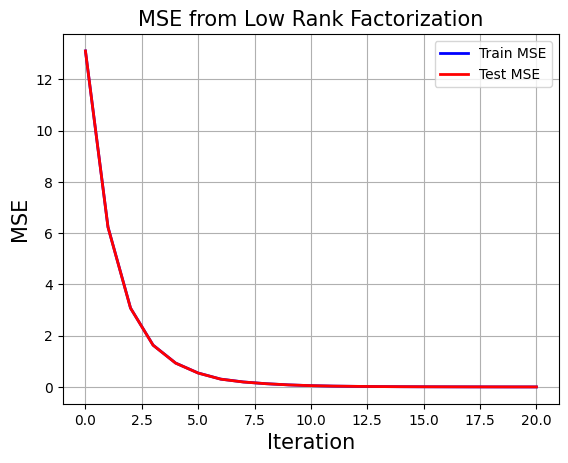

In [18]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=2, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

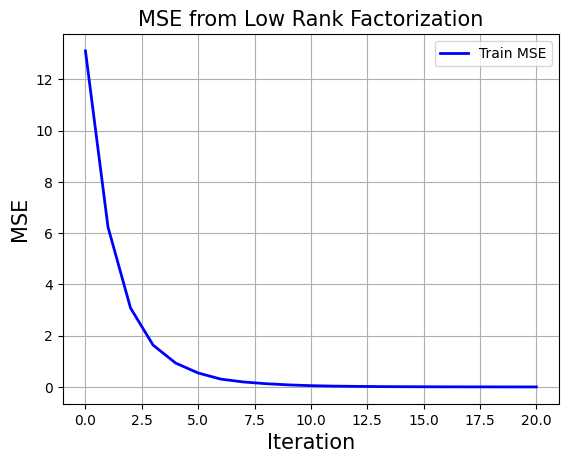

In [19]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE_nmf]
test_mse = [mse_test for _, mse_test in MSE_nmf]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')

plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

In [ ]:
test_user = combined_test_df['userID'].values
test_song = combined_test_df['songID'].values
test_song_index = [song_ids.index(song_id) for song_id in test_song]
# Compute MSE for the combined training dataset
U_batch_test = U[test_user]
S_batch_test = S[test_song_index]
ratings_batch_test = combined_test_df['rating']
MSE_test = mse(U_batch_test, S_batch_test, ratings_batch_test)
MSE_test

0.0025143757415566183